In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
rawRDD = sc.textFile('/home/dirk/code/research/names/tweets.txt').cache()

In [3]:
dictRDD = rawRDD.map(eval)

In [4]:
type(dictRDD)

pyspark.rdd.PipelinedRDD

In [5]:
type(dictRDD.take(2))

Py4JJavaError: An error occurred while calling o27.partitions.
: org.apache.hadoop.mapred.InvalidInputException: Input path does not exist: file:/home/dirk/code/research/names/tweets.txt
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:285)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:228)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:313)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:203)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:219)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:217)
	at scala.Option.getOrElse(Option.scala:120)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:217)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:32)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:219)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:217)
	at scala.Option.getOrElse(Option.scala:120)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:217)
	at org.apache.spark.api.python.PythonRDD.getPartitions(PythonRDD.scala:57)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:219)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:217)
	at scala.Option.getOrElse(Option.scala:120)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:217)
	at org.apache.spark.api.java.JavaRDDLike$class.partitions(JavaRDDLike.scala:64)
	at org.apache.spark.api.java.AbstractJavaRDDLike.partitions(JavaRDDLike.scala:46)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)


In [10]:
type(dictRDD.take(2)[0])

dict

In [11]:
sc.parallelize('abcaba').countByValue()

defaultdict(<type 'int'>, {'a': 3, 'c': 1, 'b': 2})

In [12]:
tweetCountByUser = dictRDD\
  .map(lambda x: x['user']['screen_name'])\
  .countByValue()

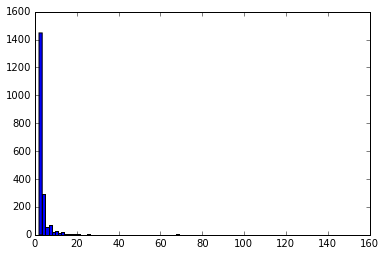

In [13]:
hist([n for n in tweetCountByUser.values() if n != 1], bins=100)
None

In [14]:
mostFollowedTen = dictRDD\
    .map(lambda x: (x['user']['screen_name'],
                    x['user']['followers_count']))\
    .reduceByKey(max)\
    .sortBy(lambda x: -x[1])\
    .take(10)

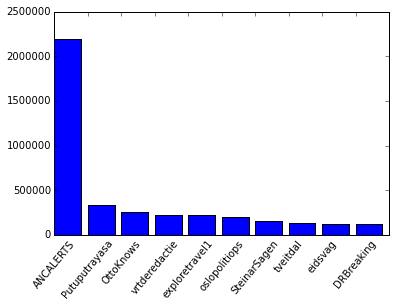

In [15]:
xvals = range(len(mostFollowedTen))
bar(xvals, [i[1] for i in mostFollowedTen])
xticks(xvals, [i[0] for i in mostFollowedTen], rotation=50)
None

In [16]:
numberOfHashtags = dictRDD\
    .map(lambda x: len(x['entities']['hashtags']))\
    .collect()

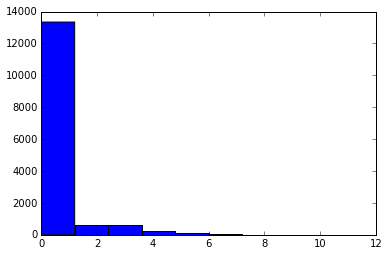

In [17]:
hist(numberOfHashtags)
None

In [18]:
# exclude users with more than 1k friends or followers
maxFollowers, maxFriends = 1000, 1000
filteredRDD = dictRDD\
    .filter(lambda x: x['user']['followers_count'] < maxFollowers)\
    .filter(lambda x: x['user']['friends_count'] < maxFriends)

In [19]:
# exclude duplicates
uniqueFilteredRDD = filteredRDD\
    .map(lambda x: (x['user']['screen_name'], (x['user']['followers_count'],
                                               x['user']['friends_count'])))\
    .reduceByKey(lambda x, y: map(max, zip(x, y)))

In [21]:
from pyspark.mllib.regression import LabeledPoint

In [123]:
data = uniqueFilteredRDD.map(lambda (_, (followers, friends)): LabeledPoint(followers, [friends]))
# data= uniqueFilteredRDD.map(lambda x: LabeledPoint(x[1][0], [x[1][1]]))

In [124]:
trainData, testData = data.randomSplit((80, 20))

In [125]:
from pyspark.mllib.regression import LinearRegressionWithSGD

In [131]:
model = LinearRegressionWithSGD.train(trainData, step=0.00001, intercept=True, iterations=100)

In [133]:
model

(weights=[0.781292718877], intercept=1.0078454624567639)

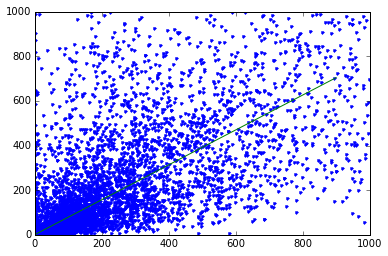

In [134]:
plot([x.features[0] for x in trainData.collect()],
     [x.label for x in trainData.collect()], '.')
f = lambda x: model.intercept + x*model.weights[0]
plot(arange(0,1000, 100), f(arange(0,1000, 100)))
None

In [135]:
squardErrors = testData.map(lambda x: (model.predict(x.features) - x.label)**2)

In [137]:
np.sqrt(squardErrors.sum()) / float(squardErrors.count() - 1)

5.3817810266021064